(advanced-tunnel)=
# Advanced tunnel example

This example will guide you through how to model more complex [](tunnel) networks in SHOP by implementing the topology shown in Figure 1. The system has three [reservoirs](reservoir), one [](plant) with two [generators](generator), and a plant with a single [](pump). All objects in the system are connected through a tunnel network. Reservoir 1 and Reservoir 2 are identical in size and elevation, but Reservoir 1 is closer to the generating plant in terms of the loss factor of the tunnel between the reservoir and plant. Reservoir 3 is only used to refill Reservoir 1 and Reservoir 2 through pumping the water directly into the tunnel network, close to Reservoir 2. In addition, there is an adjustable gate between the node and Reservoir 2 which can be closed to force all the pumped water into Reservoir 1 (and Plant 1 if it is running at the same time). When the gate is open, the water pumped into the tunnel network will be split among Reservoir 1 and Reservoir 2 (assuming Plant 1 is not operating), where most will end up in Reservoir 2 due to the loss factors in the tunnel network.

|![](advanced_tunnel_drawing.png)|
|---|
| <b>Figure 1: Topology of a more advanced tunnel network system.</b> |


The intersections connecting multiple tunnels are indicated with black dots in Figure 1, one right above Plant 1 and one named "Node" where the pumped water will enter. Note that these nodes are not represented as explicit objects in SHOP and should not be confused with the old [](junction) object. 

The corresponding SHOP model is defined in the build_model() function in the advanced_tunnel_model.py script, which is imported together with other packages below:

In [1]:
from pyshop import ShopSession
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from advanced_tunnel_model import build_model

The resulting topology is shown below:

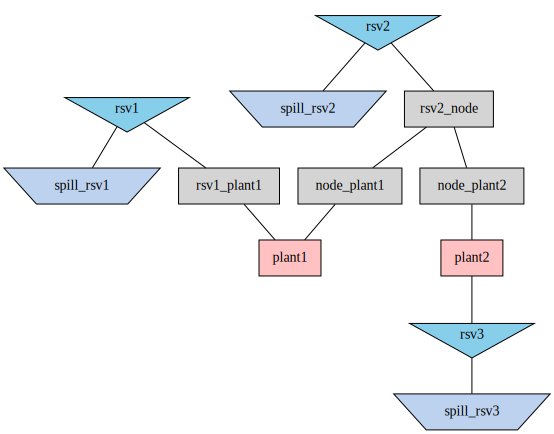

In [2]:
shop = build_model()
shop.model.build_connection_tree()

Note that the tunnel from Reservoir 1 and from the Node are connected directly to Plant 1, which assumes that the tunnel loss from the intersection above the plant is covered in the [main_loss](plant:main_loss) attribute on the plant. In this case, the main loss is set to zero. All reservoirs have connected [](river) objects that will serve as spillways to the ocean if the reservoirs are overflowing. 

The model is initialized with historical spot prices from NO1 and a slightly higher water value for Reservoir 1 compared to Reservoir 2. Reservoir 3 has a lower water value than the other reservoirs, which means that it could be beneficial to pump the water if the prices are low enough. There is zero inflow into Reservoir 1 and Reservoir 2, while Reservoir 3 has a constant inflow of 20 m3/s.

The loss factors in the four tunnels are printed below. Note that the loss from the Reservoir 2 down to Plant 1 through the tunnels "rsv2_node" and "node_plant1" is substantially higher than the loss from Reservoir 1 down to Plant 1 ("rsv1_plant1").

In [3]:
for t in shop.model.tunnel:
    print(t.get_name(), t.loss_factor.get())

rsv1_plant1 0.002
node_plant1 0.004
rsv2_node 0.001
node_plant2 0.001


## Open gate

The base model does not contain any gate in the tunnel as indicated in Figure 1. This means that the tunnel "rsv2_node" is always open in this first model run:

In [4]:
#Run a standard optimization

shop.set_universal_mip("off",[])
shop.start_sim([],[3])
shop.set_universal_mip("on",[])
shop.start_sim([],[2])
shop.set_code(['incremental'], [])
shop.start_sim([],[5])

open_tunnel_objective = shop.model.objective.average_objective.total.get()
print("Open tunnel objective:",open_tunnel_objective)

Open tunnel objective: -659181.0787454857


The figures below show that Plant 1 produces power when the prices are high, while some pumping from Plant 2 occurs in the low price hours. As the reservoir levels indicate, most of the water for production is drawn from Reservoir 1 due to the relatively high tunnel losses from Reservoir 2 down to Plant 1. Note that SHOP does not "want" to draw more water from Reservoir 1 since this has a higher water value, it is simply the physics of the tunnel network (mass and pressure balance) that enforces this behaviour:

In [5]:
#Plot production/consumption and market price
fig = make_subplots(specs=[[{"secondary_y": True}]])
fig.update_layout(barmode="stack", title="Production and market price")
fig.update_yaxes(title_text="Energy price [€/MWh]", secondary_y=True)
fig.update_yaxes(title_text="Production [MW]", secondary_y=False)

plant1_prod = shop.model.plant.plant1.production.get()
plant2_cons = shop.model.plant.plant2.consumption.get()
price = shop.model.market.spot.sale_price.get()
fig.add_trace(go.Scatter(x=plant1_prod.index, y=plant1_prod.values, name="Plant 1"))
fig.add_trace(go.Scatter(x=plant2_cons.index, y=-plant2_cons.values, name="Plant 2"))
fig.add_trace(go.Scatter(x=price.index, y=price.values, name="Price"),secondary_y=True)
fig.show()

#Plot reservoir levels of Reservoir 1 and 2
fig = go.Figure()
rsv1_head = shop.model.reservoir.rsv1.head.get()
rsv2_head = shop.model.reservoir.rsv2.head.get()
fig.add_trace(go.Scatter(x=rsv1_head.index, y=rsv1_head.values, name="Rsv 1"))
fig.add_trace(go.Scatter(x=rsv2_head.index, y=rsv2_head.values, name="Rsv 2"))
fig.update_layout(title="Reservoir levels")
fig.update_yaxes(title_text="Level [masl]")
fig.show()

The [flow](tunnel:flow) in the tunnel network is shown below, and confirms that most of the pumped water ends up in Reservoir 2 instead of Reservoir 1. The split is about 70/30, which is again due to the mass and pressure balance of the tunnel network at each point in time.

Note that the tunnel flow does not deviate from the post-calculated [physical flow](tunnel:physical_flow) attribute, which means that the linearization of the tunnel network equations is stable.

In [6]:
#Plot the flow in all tunnels, negative values indicate flow in the opposite direction of the connection
fig = go.Figure()
for t in shop.model.tunnel:
    flow = t.flow.get()
    fig.add_trace(go.Scatter(x=flow.index, y=flow.values, name=t.get_name()))

fig.update_layout(title="Tunnel flow")
fig.update_yaxes(title_text="Flow [m3/s]")
fig.show()

#Plot the deviation of the flow from the post-calculated flow
fig = go.Figure()
for t in shop.model.tunnel:
    flow = t.flow.get()
    pflow = t.physical_flow.get()
    fig.add_trace(go.Scatter(x=flow.index, y=flow.values-pflow.values, name=t.get_name()))

fig.update_layout(title="Optimized tunnel flow deviation from post-calculated flow")
fig.update_yaxes(title_text="Flow [m3/s]")
fig.show()

## Gate optimization

Now, an adjustable gate can be inserted in tunnel "rsv2_node". Instead of having the tunnel open at all times like in the first model run, SHOP can now optimize the gate opening. The gate is modelled as a binary gate, which is either fully open or fully closed. A [gate_adjustment_cost](tunnel:gate_adjustment_cost) of 1000 € is added to the gate to avoid excessive switching of the gate position between time steps. Gate optimization problems are in general difficult to solve as the gate position can drastically change the flow in the network. For this system, it is beneficial to set the CPLEX parameter "Mip emphasis switch" (id 2058) to 3, which means that CPLEX will prioritize shrinking in the best bound for the MIP problem (see the CPLEX documentation https://www.ibm.com/docs/en/icos/20.1.0?topic=parameters-mip-emphasis-switch). Any integer CPLEX parameter can be set with the [cplex_int_params](global_settings:cplex_int_params) attribute. The MIP gap is also set to 1500 €, which is the same as adjusting the gate position 1.5 times.

In [7]:
shop = build_model()

#Add a binary gate
t3 = shop.model.tunnel["rsv2_node"]
t3.gate_opening_curve.set(pd.Series([0,1], index=[0,1]))
t3.initial_opening.set(1)
t3.gate_adjustment_cost.set(1000)

gs = shop.model.global_settings.global_settings
gs.cplex_int_params.set(pd.Series([3],index=[2058]))

#Run a standard optimization model
shop.set_mipgap("absolute",1500)
shop.set_universal_mip("off",[])
shop.start_sim([],[3])
shop.set_universal_mip("on",[])
shop.start_sim([],[2])
shop.set_code(['incremental'], [])
shop.start_sim([],[5])

optimized_gate_objective = shop.model.objective.average_objective.total.get()
print("Optimized gate objective:",optimized_gate_objective)
print("Difference from open tunnel objective:",optimized_gate_objective - open_tunnel_objective)

Optimized gate objective: -666358.3709399446
Difference from open tunnel objective: -7177.292194458889


The objective function has improved when the gate position is free to optimize. The figures below show that the gate is mostly open, but it is closed off in two periods towards the end of the optimization to allow all of the pumped water from Reservoir 3 to flow into Reservoir 1 instead of mostly into Reservoir 2. This makes it possible to draw down Reservoir 2 more than Reservoir 1, which has a higher water value.

In [8]:
#Plot resulting gate opening
gate_opening = t3.gate_opening.get()
fig = go.Figure()
fig.add_trace(go.Scatter(x=gate_opening.index, y=gate_opening.values, name=t3.get_name()))
fig.update_layout(title="Gate opening")
fig.show()

#Plot production/consumption and market price
fig = make_subplots(specs=[[{"secondary_y": True}]])
fig.update_layout(barmode="stack", title="Production and market price")
fig.update_yaxes(title_text="Energy price [€/MWh]", secondary_y=True)
fig.update_yaxes(title_text="Production [MW]", secondary_y=False)

plant1_prod = shop.model.plant.plant1.production.get()
plant2_cons = shop.model.plant.plant2.consumption.get()
price = shop.model.market.spot.sale_price.get()
fig.add_trace(go.Scatter(x=plant1_prod.index, y=plant1_prod.values, name="Plant 1"))
fig.add_trace(go.Scatter(x=plant2_cons.index, y=-plant2_cons.values, name="Plant 2"))
fig.add_trace(go.Scatter(x=price.index, y=price.values, name="Price"),secondary_y=True)
fig.show()

#Plot reservoir levels
fig = go.Figure()
rsv1_head = shop.model.reservoir.rsv1.head.get()
rsv2_head = shop.model.reservoir.rsv2.head.get()
fig.add_trace(go.Scatter(x=rsv1_head.index, y=rsv1_head.values, name="Rsv 1"))
fig.add_trace(go.Scatter(x=rsv2_head.index, y=rsv2_head.values, name="Rsv 2"))
fig.update_layout(title="Reservoir levels")
fig.update_yaxes(title_text="Level [masl]")
fig.show()

As the flows in the tunnel network show, all the pumped water flows into Reservoir 1 when the gate is closed. Note that the gate is left open in the first pumping period that lasts for 1 hour, this is likely due to the gate adjustment cost of 1000 € making it unprofitable to change.

In [9]:
#Plot tunnel flow
fig = go.Figure()
for t in shop.model.tunnel:
    flow = t.flow.get()
    fig.add_trace(go.Scatter(x=flow.index, y=flow.values, name=t.get_name()))

fig.update_layout(title="Tunnel flow")
fig.update_yaxes(title_text="Flow [m3/s]")
fig.show()

#Plot deviation from post-calculated tunnel flow
fig = go.Figure()
for t in shop.model.tunnel:
    flow = t.flow.get()
    pflow = t.physical_flow.get()
    fig.add_trace(go.Scatter(x=flow.index, y=flow.values-pflow.values, name=t.get_name()))

fig.update_layout(title="Optimized tunnel flow deviation from post-calculated flow")
fig.update_yaxes(title_text="Flow [m3/s]")
fig.show()

## advanced_tunnel_model.py

In [10]:
with open('advanced_tunnel_model.py', 'r') as f:
    print(f.read())

import pandas as pd
from pyshop import ShopSession

def build_model():
    
    shop = ShopSession()
    starttime = pd.Timestamp('2022-04-16')
    endtime = pd.Timestamp('2022-04-19')
    shop.set_time_resolution(starttime=starttime, endtime=endtime, timeunit='hour')    
    
    rsv1 = shop.model.reservoir.add_object("rsv1")
    rsv1.max_vol.set(12)
    rsv1.lrl.set(90)
    rsv1.hrl.set(100)
    rsv1.vol_head.set(pd.Series([90, 100, 101], index=[0, 12, 14], name=0))

    spill1 = shop.model.river.add_object("spill_rsv1")
    spill1.upstream_elevation.set(100)
    spill1.up_head_flow_curve.set([pd.Series([0,1000],index=[100,101], name=0)])
    spill1.flow_cost.set(100)
    rsv1.connect_to(spill1)
    
    rsv2 = shop.model.reservoir.add_object("rsv2")
    rsv2.max_vol.set(12)
    rsv2.lrl.set(90)
    rsv2.hrl.set(100)
    rsv2.vol_head.set(pd.Series([90, 100, 101], index=[0, 12, 14], name=0))

    spill2 = shop.model.river.add_object("spill_rsv2")
    spill2.upstream_elevation.set(100